In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os 

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU .")
else:
    print("CPU.")

GPU .


In [3]:
# Définir les transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner les images à 128x128
    transforms.ToTensor()           # Convertir les images en tenseurs PyTorch
])

In [4]:
# Charger les données d'entraînement et de validation
train_data = datasets.ImageFolder('dataset/train', transform=transform)
val_data = datasets.ImageFolder('dataset/valid', transform=transform)

In [5]:
# Créer les DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True,pin_memory=True,num_workers=os.cpu_count())
val_loader = DataLoader(val_data, batch_size=32, shuffle=False,pin_memory=True,num_workers=os.cpu_count())

In [6]:
len(train_data)

84635

In [7]:
len(val_data)

2625

In [8]:
len(train_data.classes)

525

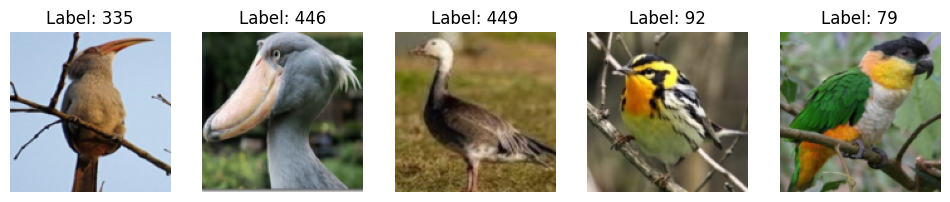

In [9]:
# Obtenir un batch d'images
images, labels = next(iter(train_loader))

# Afficher les premières images du batch
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')
plt.show()

In [10]:
images.shape

torch.Size([32, 3, 128, 128])

In [11]:
class ImageCNN(nn.Module):
    def __init__(self):
        super(ImageCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)   
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)    
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(p=0.5)

        
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)  # Updated for more neurons due to more convolution layers
        self.fc2 = nn.Linear(1024, num_classes)
        

    def forward(self, x):    #32,3,128,128 
        x = self.dropout(self.bn1(F.relu(self.pool(self.conv1(x))))) #32,32,64,64
        x = self.dropout(self.bn2(F.relu(self.pool(self.conv2(x)))))#32,64,32,32
        x = self.dropout(self.bn3(F.relu(self.pool(self.conv3(x))))) #32,128,16,16
        x = self.dropout(self.bn4(F.relu(self.pool(self.conv4(x))))) #32,256,8,8
        x = x.view((len(x),-1))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Instancier le modèle
num_classes = len(train_data.classes)
model = ImageCNN()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ImageCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=525, bias=True)
)

In [14]:
# Entraîner le modèle
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Initialiser les gradients à zéro
        optimizer.zero_grad()

        # Avant
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Arrière
        loss.backward()

        # Optimiser
        optimizer.step()

        # Afficher les statistiques
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    print(f"Époque {epoch+1}, Perte d'entraînement: {train_loss:.4f}")

     # Calculer la perte et la précision sur le jeu de validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Époque {epoch+1}, Perte de validation: {val_loss:.4f}, Précision de validation: {val_accuracy:.2f}%")

print('Entraînement terminé')

# Sauvegarder le modèle
torch.save(model.state_dict(), 'model.pth')

# Charger le modèle
model =ImageCNN()
model.load_state_dict(torch.load('model.pth'))
model.to(device)
model.eval()  # Mettre le modèle en mode évaluation


Époque 1, Perte d'entraînement: 5.3054
Époque 1, Perte de validation: 4.7138, Précision de validation: 6.13%
Époque 2, Perte d'entraînement: 4.3012
Époque 2, Perte de validation: 4.9893, Précision de validation: 8.91%
Époque 3, Perte d'entraînement: 3.7926
Époque 3, Perte de validation: 3.7052, Précision de validation: 21.14%
Époque 4, Perte d'entraînement: 3.3335
Époque 4, Perte de validation: 3.9685, Précision de validation: 22.90%
Époque 5, Perte d'entraînement: 2.8293
Époque 5, Perte de validation: 2.6658, Précision de validation: 41.14%
Époque 6, Perte d'entraînement: 2.3837
Époque 6, Perte de validation: 2.2642, Précision de validation: 48.30%
Époque 7, Perte d'entraînement: 2.0073
Époque 7, Perte de validation: 2.9027, Précision de validation: 41.68%
Époque 8, Perte d'entraînement: 1.6808
Époque 8, Perte de validation: 2.2951, Précision de validation: 52.27%
Époque 9, Perte d'entraînement: 1.3998
Époque 9, Perte de validation: 2.9302, Précision de validation: 48.00%
Époque 10, P

ImageCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=525, bias=True)
)